# Aims

The purpose of this notebook is to follow the article but instead of using the proposed Tehran Securities Exchange Technology Management Co (TSETMC) use some common data.

# Imports

In [1]:
import sys
sys.path.append("./../..")

In [2]:
from money_machine.data import dataset
import pandas_datareader.data as web

import datetime as dt
import numpy as np
import pandas as pd
import pandas_ta as pta

In [3]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, LSTM

In [4]:
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

# Choose the companies

In [5]:
companies_to_tickers = {"Nike": "NKE", 
                       "Goldman Sachs": "GS", 
                       "Johnson and Johnson": "JNJ", 
                       "Pfizer": "PFE",
                       "JP Morgan Chase and Co": "JPM"}

In [6]:
tickers = list(companies_to_tickers.values())
tickers

['NKE', 'GS', 'JNJ', 'PFE', 'JPM']

In [7]:
web.DataReader("NKE", "yahoo", dt.datetime(2021, 12, 20), dt.datetime(2021, 12, 25))

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-12-20,159.6000,155.4700,159.3400,156.9800,8411900,156.9800
2021-12-21,171.1900,164.7100,166.6900,166.6300,13862900,166.6300
2021-12-22,169.0000,164.0900,167.2400,165.4400,5811300,165.4400
2021-12-23,167.1600,165.4400,166.2500,165.6700,3876200,165.6700


# Data

## Load

In [92]:
start_train = dt.datetime(2009, 4, 6)
end_train = dt.datetime(2017, 4, 4)
start_test = end_train
end_test = dt.datetime(2019, 4, 5)

In [9]:
data_full = dataset.load_data(["NKE"], start_train, end_test)

In [10]:
data_train = {ticker: web.DataReader(ticker, "yahoo", start_train, end_train)
             for ticker in tickers}
data_test = {ticker: web.DataReader(ticker, "yahoo", start_test, end_test)
             for ticker in tickers}

In [11]:
print(tickers[0])
data_train[tickers[0]].head()

NKE


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-04-06,12.8750,12.6150,12.8200,12.8175,11080000.0000,10.9484
2009-04-07,12.5950,12.3775,12.5925,12.4650,11580000.0000,10.6473
2009-04-08,12.6550,12.3625,12.4900,12.5600,13103200.0000,10.7284
2009-04-09,13.3750,12.6450,12.8125,13.3175,18044400.0000,11.3755
2009-04-13,13.3675,12.8975,13.1825,13.2800,13202000.0000,11.3434


In [12]:
nike = data_full[tickers[0]].copy()

In [13]:
nike_train = data_train[tickers[0]].copy()
nike_test = data_test[tickers[1]].copy()

In [14]:
nike_train.shape

(2013, 6)

## Cleaning

### Check for missing values

In [15]:
data_train[tickers[0]].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2013 entries, 2009-04-06 to 2017-04-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2013 non-null   float64
 1   Low        2013 non-null   float64
 2   Open       2013 non-null   float64
 3   Close      2013 non-null   float64
 4   Volume     2013 non-null   float64
 5   Adj Close  2013 non-null   float64
dtypes: float64(6)
memory usage: 110.1 KB


In [16]:
data_train[tickers[0]].describe()

,High,Low,Open,Close,Volume,Adj Close
count,2013.0000,2013.0000,2013.0000,2013.0000,2013.0000,2013.0000
mean,34.6134,34.0142,34.3111,34.3221,9921541.0333,31.4956
std,15.7336,15.4880,15.6224,15.6078,5900698.2265,15.1412
min,12.5950,12.1900,12.3500,12.3800,2302000.0000,10.5747
25%,21.2000,20.7650,20.9725,21.0150,6662600.0000,18.5301
50%,29.9900,29.4500,29.6750,29.7800,8578000.0000,27.0447
75%,50.1700,49.4700,49.8650,49.8050,11448000.0000,46.4680
max,68.1950,66.6650,68.1200,67.1650,86339600.0000,62.8565


noting suspicious in the min, max

### Interquartile Range (IQR)

It seems it is particulary usefull for NON-normal distriubuted data. 

In [17]:
#TODO: check if it's normal

In [18]:
Q1 = data_train[tickers[0]].quantile(0.25)
Q3 = data_train[tickers[0]].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

High             28.9700
Low              28.7050
Open             28.8925
Close            28.7900
Volume      4785400.0000
Adj Close        27.9379
dtype: float64


In [19]:
k = 1.5
((data_train[tickers[0]] < (Q1 - k * IQR)) |(data_train[tickers[0]] > (Q3 + k * IQR))).sum()

High           0
Low            0
Open           0
Close          0
Volume       106
Adj Close      0
dtype: int64

#### far outs

In [20]:
k = 3
((data_train[tickers[0]] < (Q1 - k * IQR)) |(data_train[tickers[0]] > (Q3 + k * IQR))).sum()

High          0
Low           0
Open          0
Close         0
Volume       36
Adj Close     0
dtype: int64

Volume is worth checking cause there are some outliers

## New data creation

The article proposes the following data:

In [21]:
n = 15
t = pd.DataFrame(np.arange(n), columns=["Close"]) #testing dataframe

In [22]:
from numpy.random import default_rng
rng = default_rng()
vals = rng.integers(-10, 10, n)

In [23]:
t["Close"] += vals

In [24]:
t["High"] = t["Close"] + 1
t["Low"] = t["Close"] -2

### n-day moving average

In [25]:
def moving_average(data, n):
    data["MA-14d"] = data["Close"].rolling(window=n).mean()
    return data

### Weighted 14-day moving average

In [26]:
def weighted_moving_average(data, n):
    weights = np.linspace(1, n, n)
    sum_weights = np.sum(weights)
    data[f"WMA-{n}d"] = data["Close"].rolling(window=n).apply(lambda x: np.sum(weights * x /sum_weights))
    return data

### Momentum

I am not sure if they defined it properly.<br>I would rather define it as M(t) = C(t) - C(t-n); they added + 1.<br>But it does not work for 1 day momentum.

In [27]:
def momentum(data, n):
    assert n > 0, f"Momentum can be computed only with regard to the older values. Give positve n istead of {n}"
    data[f"Momentum-{n}days"] = data["Close"] - np.roll(data["Close"], n)
    data[f"Momentum-{n}days"][:n] = np.nan
    return data

In [28]:
momentum(t, 7)

,Close,High,Low,Momentum-7days
0,2,3,0,NaN
1,-8,-7,-10,NaN
2,-1,0,-3,NaN
3,8,9,6,NaN
4,9,10,7,NaN
5,-5,-4,-7,NaN
6,13,14,11,NaN
7,16,17,14,14.0000
8,2,3,0,10.0000
9,16,17,14,17.0000


### Stochastic K%

In [29]:
def lowest_close_n(data, n):
    n_min = data["Close"].rolling(window=n).apply(lambda x: np.min(x))
    return n_min

In [30]:
def highest_close_n(data, n):
    n_max = data["Close"].rolling(window=n).apply(lambda x: np.max(x))
    return n_max

In [31]:
def stochastic_k_percent(data, n):
    n_min = lowest_close_n(data, n)
    n_max = highest_close_n(data, n)
    numerator = data["Close"] - n_min
    denominator = n_max - n_min
    data[f"stochastic_k_percent-{n}d"] = numerator/denominator * 100
    return data

#### Test

In [32]:
data = t
n = 3
n_min = lowest_close_n(data, n)
n_max = highest_close_n(data, n)

In [33]:
data["Close"] - n_min

0        NaN
1        NaN
2     7.0000
3    16.0000
4    10.0000
5     0.0000
6    18.0000
7    21.0000
8     0.0000
9    14.0000
10    6.0000
11    5.0000
12    0.0000
13    0.0000
14    5.0000
Name: Close, dtype: float64

In [34]:
n_max - n_min

0        NaN
1        NaN
2    10.0000
3    16.0000
4    10.0000
5    14.0000
6    18.0000
7    21.0000
8    14.0000
9    14.0000
10   14.0000
11    8.0000
12    5.0000
13    7.0000
14    5.0000
Name: Close, dtype: float64

In [35]:
data = stochastic_k_percent(data, n)

In [36]:
data

,Close,High,Low,Momentum-7days,stochastic_k_percent-3d
0,2,3,0,NaN,NaN
1,-8,-7,-10,NaN,NaN
2,-1,0,-3,NaN,70.0000
3,8,9,6,NaN,100.0000
4,9,10,7,NaN,100.0000
5,-5,-4,-7,NaN,0.0000
6,13,14,11,NaN,100.0000
7,16,17,14,14.0000,100.0000
8,2,3,0,10.0000,0.0000
9,16,17,14,17.0000,100.0000


In [37]:
stochastic_k_percent(nike.copy(), 7)

,High,Low,Open,Close,Volume,Adj Close,stochastic_k_percent-7d
Date,,,,,,,
2009-04-06,12.8750,12.6150,12.8200,12.8175,11080000.0000,10.9484,NaN
2009-04-07,12.5950,12.3775,12.5925,12.4650,11580000.0000,10.6473,NaN
2009-04-08,12.6550,12.3625,12.4900,12.5600,13103200.0000,10.7284,NaN
2009-04-09,13.3750,12.6450,12.8125,13.3175,18044400.0000,11.3755,NaN
2009-04-13,13.3675,12.8975,13.1825,13.2800,13202000.0000,11.3434,NaN
...,...,...,...,...,...,...,...
2019-04-01,85.3200,84.7000,85.0400,85.2300,6737400.0000,83.1305,100.0000
2019-04-02,85.2600,84.1600,85.0000,84.3700,4433800.0000,82.2917,70.3448
2019-04-03,84.9900,84.2500,84.9000,84.4700,4080900.0000,82.3892,64.4860


### Stochastic d percent

I don't multiply it by 100 as described in the paper

In [38]:
def stochastic_d_percent(data, n, n_stochastic_k_percents=None):
    if n_stochastic_k_percents == None:
        n_stochastic_k_percents = n
    data[f"stochastic_d_percent-{n}d"] = data[
        f"stochastic_k_percent-{n_stochastic_k_percents}d"].rolling(window=n).mean()
    return data

## Relative strength index (RSI) 

In [39]:
def rsi(data, n):
    data[f"rsi-{n}d"] = pta.rsi(data['Close'], length = n)
    return data

## Signal(n)

In [40]:
def signal_macd(data, n):
    macd = pta.macd(data["Close"], fast=12, slow=26, signal=n)
    signal = macd.iloc[:, -1]
    data[signal.name] = signal
    return data

## Larry William’s R%

In [41]:
def larry_wiliams_R(data, n):
    n_min = lowest_close_n(data, n)
    n_max = highest_close_n(data, n)
    numerator = n_max - data["Close"] 
    denominator = n_max - n_min
    data[f"larry_wiliams_R-{n}d"] = numerator/denominator * 100
    return data

## Accumulation/Distribution (A/D) oscillator

In [42]:
def a_d_oscillator(data, n):
    nominator = data["High"] - data["Close"]
    denominator = data["High"] - data["Low"]
    data["a_d_oscillator"] = nominator/denominator
    return data

## CCI (Commodity channel index)  

In [43]:
def cci(data, n):
    data[f"cci-{n}d"] = pta.cci(data["High"], data["Low"], data["Close"], n)
    return data

# Combine the data

In [44]:
new_data_fncs = [moving_average, 
                 weighted_moving_average, 
                 momentum, 
                 stochastic_k_percent, 
                 stochastic_d_percent, 
                 rsi, 
                 larry_wiliams_R,
                 signal_macd,
                 a_d_oscillator,
                 cci]

In [45]:
def add_new_data(data, n):
    for fn in new_data_fncs:
        data = fn(data, n)
    return data

In [46]:
nike = add_new_data(nike, n=14)

In [47]:
nike

,High,Low,Open,Close,Volume,Adj Close,MA-14d,WMA-14d,Momentum-14days,stochastic_k_percent-14d,stochastic_d_percent-14d,rsi-14d,larry_wiliams_R-14d,MACDs_12_26_14,a_d_oscillator,cci-14d
Date,,,,,,,,,,,,,,,,
2009-04-06,12.8750,12.6150,12.8200,12.8175,11080000.0000,10.9484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2212,NaN
2009-04-07,12.5950,12.3775,12.5925,12.4650,11580000.0000,10.6473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5977,NaN
2009-04-08,12.6550,12.3625,12.4900,12.5600,13103200.0000,10.7284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3248,NaN
2009-04-09,13.3750,12.6450,12.8125,13.3175,18044400.0000,11.3755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0788,NaN
2009-04-13,13.3675,12.8975,13.1825,13.2800,13202000.0000,11.3434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1862,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-01,85.3200,84.7000,85.0400,85.2300,6737400.0000,83.1305,85.3057,84.6545,-0.2000,52.2337,52.6093,52.4544,47.7663,0.5631,0.1452,-10.0367
2019-04-02,85.2600,84.1600,85.0000,84.3700,4433800.0000,82.2917,85.1943,84.5297,-1.5600,37.4571,51.8027,48.8491,62.5429,0.4850,0.8091,-25.3183
2019-04-03,84.9900,84.2500,84.9000,84.4700,4080900.0000,82.3892,85.0229,84.4331,-2.4000,39.1752,48.3358,49.2856,60.8248,0.4156,0.7027,-22.0051


# Create y label

In [48]:
def y_label_for_n_day_pred(data, n):
    """
    Creates labels for prediction of n days ahead.
    
    Args:
        data: data from which the labels will be created (has to have "Close" column)
        n: the number of days ahead for prediction
    Returns:
        labels, shape[0] == data.shape[0]
    """
    y = data["Close"].shift(-n)
    y.name = "y"
    return y

In [49]:
def append_y(data, n):
    return pd.concat([data, y_label_for_n_day_pred(data, n)], axis=1)

In [50]:
nike = append_y(nike, 7)

In [51]:
nike

,High,Low,Open,Close,Volume,Adj Close,MA-14d,WMA-14d,Momentum-14days,stochastic_k_percent-14d,stochastic_d_percent-14d,rsi-14d,larry_wiliams_R-14d,MACDs_12_26_14,a_d_oscillator,cci-14d,y
Date,,,,,,,,,,,,,,,,,
2009-04-06,12.8750,12.6150,12.8200,12.8175,11080000.0000,10.9484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2212,NaN,13.4425
2009-04-07,12.5950,12.3775,12.5925,12.4650,11580000.0000,10.6473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5977,NaN,13.6525
2009-04-08,12.6550,12.3625,12.4900,12.5600,13103200.0000,10.7284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3248,NaN,13.0900
2009-04-09,13.3750,12.6450,12.8125,13.3175,18044400.0000,11.3755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0788,NaN,13.3175
2009-04-13,13.3675,12.8975,13.1825,13.2800,13202000.0000,11.3434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1862,NaN,13.7500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-01,85.3200,84.7000,85.0400,85.2300,6737400.0000,83.1305,85.3057,84.6545,-0.2000,52.2337,52.6093,52.4544,47.7663,0.5631,0.1452,-10.0367,NaN
2019-04-02,85.2600,84.1600,85.0000,84.3700,4433800.0000,82.2917,85.1943,84.5297,-1.5600,37.4571,51.8027,48.8491,62.5429,0.4850,0.8091,-25.3183,NaN
2019-04-03,84.9900,84.2500,84.9000,84.4700,4080900.0000,82.3892,85.0229,84.4331,-2.4000,39.1752,48.3358,49.2856,60.8248,0.4156,0.7027,-22.0051,NaN


In [52]:
nike.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2009-04-06 to 2019-04-05
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   High                      2518 non-null   float64
 1   Low                       2518 non-null   float64
 2   Open                      2518 non-null   float64
 3   Close                     2518 non-null   float64
 4   Volume                    2518 non-null   float64
 5   Adj Close                 2518 non-null   float64
 6   MA-14d                    2505 non-null   float64
 7   WMA-14d                   2505 non-null   float64
 8   Momentum-14days           2504 non-null   float64
 9   stochastic_k_percent-14d  2505 non-null   float64
 10  stochastic_d_percent-14d  2492 non-null   float64
 11  rsi-14d                   2504 non-null   float64
 12  larry_wiliams_R-14d       2505 non-null   float64
 13  MACDs_12_26_14            2480 non-null   flo

## Remove nans

In [53]:
nike

,High,Low,Open,Close,Volume,Adj Close,MA-14d,WMA-14d,Momentum-14days,stochastic_k_percent-14d,stochastic_d_percent-14d,rsi-14d,larry_wiliams_R-14d,MACDs_12_26_14,a_d_oscillator,cci-14d,y
Date,,,,,,,,,,,,,,,,,
2009-04-06,12.8750,12.6150,12.8200,12.8175,11080000.0000,10.9484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2212,NaN,13.4425
2009-04-07,12.5950,12.3775,12.5925,12.4650,11580000.0000,10.6473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5977,NaN,13.6525
2009-04-08,12.6550,12.3625,12.4900,12.5600,13103200.0000,10.7284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3248,NaN,13.0900
2009-04-09,13.3750,12.6450,12.8125,13.3175,18044400.0000,11.3755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0788,NaN,13.3175
2009-04-13,13.3675,12.8975,13.1825,13.2800,13202000.0000,11.3434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1862,NaN,13.7500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-01,85.3200,84.7000,85.0400,85.2300,6737400.0000,83.1305,85.3057,84.6545,-0.2000,52.2337,52.6093,52.4544,47.7663,0.5631,0.1452,-10.0367,NaN
2019-04-02,85.2600,84.1600,85.0000,84.3700,4433800.0000,82.2917,85.1943,84.5297,-1.5600,37.4571,51.8027,48.8491,62.5429,0.4850,0.8091,-25.3183,NaN
2019-04-03,84.9900,84.2500,84.9000,84.4700,4080900.0000,82.3892,85.0229,84.4331,-2.4000,39.1752,48.3358,49.2856,60.8248,0.4156,0.7027,-22.0051,NaN


In [54]:
nike = nike.dropna(axis=0)

In [55]:
nike["y"].iloc[0]

14.262499809265137

In [56]:
nike["Close"].iloc[14]

14.175000190734863

In [57]:
nike["y"].iloc[0] == nike["Close"].iloc[13]

False

In [58]:
nike.iloc[-15:]

,High,Low,Open,Close,Volume,Adj Close,MA-14d,WMA-14d,Momentum-14days,stochastic_k_percent-14d,stochastic_d_percent-14d,rsi-14d,larry_wiliams_R-14d,MACDs_12_26_14,a_d_oscillator,cci-14d,y
Date,,,,,,,,,,,,,,,,,
2019-03-07,85.4100,84.6600,84.9700,85.2600,4321800.0000,83.1598,85.3571,85.5280,0.5800,40.8100,76.1821,58.6502,59.1900,1.7089,0.2000,-32.1477,87.8200
2019-03-08,84.8800,84.0200,84.5800,84.8000,4669700.0000,82.7111,85.3157,85.4537,-0.5800,26.4799,70.9583,55.6400,73.5201,1.6444,0.0930,-78.6906,87.6900
2019-03-11,85.9400,85.0500,85.3900,85.8200,3999800.0000,83.7060,85.4050,85.5210,1.2500,58.2554,69.4155,60.4832,41.7446,1.5830,0.1348,21.7773,86.6900
2019-03-12,86.0800,85.0200,85.7800,85.4300,4431600.0000,83.3256,85.4471,85.5243,0.5900,46.1059,66.5942,57.8811,53.8941,1.5197,0.6132,6.0580,88.0100
2019-03-13,86.6600,85.6000,85.7000,85.9300,5037800.0000,83.8133,85.5886,85.5887,1.9800,48.7499,65.5960,60.2426,51.2501,1.4604,0.6887,63.5359,82.1900
2019-03-14,86.8800,85.7000,86.1500,86.8700,5906100.0000,84.7301,85.7393,85.7595,2.1100,87.7118,66.0589,64.2957,12.2882,1.4141,0.0085,107.9060,82.3300
2019-03-15,87.6100,85.9600,87.2200,86.8000,11031400.0000,84.6618,85.8557,85.9010,1.6300,84.7457,65.5097,63.7743,15.2543,1.3754,0.4909,124.3936,83.3800
2019-03-18,87.8400,87.0000,87.3000,87.8200,7750700.0000,85.6567,86.0000,86.1629,2.0200,100.0000,65.5097,67.8638,0.0000,1.3521,0.0238,169.0402,83.0900
2019-03-19,88.5900,87.2900,88.2200,87.6900,6642200.0000,85.5299,86.1086,86.3882,1.5200,95.6955,65.2022,66.8284,4.3045,1.3368,0.6923,153.3869,84.0400


# Devide the data

In [59]:
nike_train, nike_test = nike.loc[:pd.Timestamp(end_train)], nike.loc[pd.Timestamp(start_test):]

In [60]:
nike_test

,High,Low,Open,Close,Volume,Adj Close,MA-14d,WMA-14d,Momentum-14days,stochastic_k_percent-14d,stochastic_d_percent-14d,rsi-14d,larry_wiliams_R-14d,MACDs_12_26_14,a_d_oscillator,cci-14d,y
Date,,,,,,,,,,,,,,,,,
2017-04-04,55.3000,54.8300,55.1500,55.0400,8843300.0000,52.4136,56.3814,55.9950,-2.6200,23.5295,51.3483,42.5724,76.4705,0.1961,0.5532,-87.0668,55.3400
2017-04-05,55.8000,54.5000,54.9700,54.9800,7722100.0000,52.3565,56.1943,55.8082,-2.6200,22.2689,47.3684,42.2525,77.7311,0.1377,0.6308,-75.9799,56.2400
2017-04-06,55.9400,54.9400,55.0700,55.1400,6692200.0000,52.5089,56.0043,55.6676,-2.6600,25.6303,42.7301,43.4721,74.3697,0.0815,0.8000,-52.0584,56.1100
2017-04-07,55.2400,54.7700,55.1000,55.1100,6078300.0000,52.4803,55.7493,55.5484,-3.5700,29.0954,37.6655,43.2875,70.9046,0.0284,0.2766,-68.3823,55.8600
2017-04-10,55.3300,54.7200,55.0000,54.9000,5472700.0000,52.2803,55.5271,55.4351,-3.1100,35.5073,35.1217,41.9448,64.4927,-0.0227,0.7049,-66.2900,56.4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-21,88.1200,86.8300,87.2400,88.0100,10386900.0000,85.8420,86.2379,86.7101,0.8500,100.0000,63.3545,64.9244,0.0000,1.3012,0.0853,115.7426,85.2300
2019-03-22,85.9000,82.1500,85.2000,82.1900,21659800.0000,80.1654,85.9914,86.1704,-3.4500,0.0000,59.5939,39.2712,100.0000,1.2299,0.9893,-176.1882,84.3700
2019-03-25,83.2200,80.8900,81.4800,82.3300,15558300.0000,80.3020,85.7693,85.6822,-3.1100,2.4055,56.4502,39.8865,97.5945,1.1218,0.3820,-194.3458,84.4700


## Scaling

I don't get if they only min-max scaled the newly added features or all. It seems odd to scale only part of the features so I'll scale all of them for now.<br>
I think they didn't use the single data for the non-artificial intelligence methods.

In [61]:
skaler = MinMaxScaler()

In [62]:
nike_train_transformed = skaler.fit_transform(nike_train)
nike_test_transformed = skaler.transform(nike_test)

In [63]:
nike_X_train, nike_y_train = nike_train_transformed[:, :-1], nike_train_transformed[:, -1]
nike_X_test, nike_y_test = nike_test_transformed[:, :-1], nike_test_transformed[:, -1]

In [64]:
nike_X_train = np.expand_dims(nike_X_train, 1)
nike_X_test = np.expand_dims(nike_X_test, 1)

# Model

### Weights and Biases

In [65]:
import wandb
from wandb.keras import WandbCallback
wandb.init(project="my-test-project", reinit=True)

wandb: Currently logged in as: adam-narozniak (use `wandb login --relogin` to force relogin)


In [66]:
config = {
    "epochs": 50,
    "batch_size": 1,
    "model": "one-layer-LSTM",
    "neurons": 200
}

In [67]:
wandb.config.update({"dataset": "nike-X-scaled-y-skaled"})

In [68]:
batch_size = 16
neurons = 200

In [69]:
nike_X_train.shape

(1975, 1, 16)

In [70]:
model = Sequential()
#model.add(Input(shape=(nike_X_train.shape[1], nike_X_train.shape[2])))
model.add(LSTM(config["neurons"], stateful=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

2021-12-27 19:47:50.655553: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [71]:
history = model.fit(nike_X_train, nike_y_train, epochs=50, shuffle=False, callbacks=[WandbCallback()])

Epoch 1/50
62/62 [==============================] - 2s 2ms/step - loss: 0.0034
Epoch 2/50
62/62 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 3/50
62/62 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 4/50
62/62 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 5/50
62/62 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch 6/50
62/62 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 7/50
62/62 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 8/50
62/62 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 9/50
62/62 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 10/50
62/62 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 11/50
62/62 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 12/50
62/62 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 13/50
62/62 [==============================

In [74]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▃█▇▆▃▂▁▁▂▂▃▃▄▅▅▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
loss,0.00149


In [75]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               173600    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 173,801
Trainable params: 173,801
Non-trainable params: 0
_________________________________________________________________


In [76]:
y_pred = model.predict(nike_X_test)

In [77]:
y_pred

array([[0.8337374 ],
       [0.82870555],
       [0.82611185],
       [0.83041817],
       [0.82363874],
       [0.80225956],
       [0.819936  ],
       [0.8116    ],
       [0.8373649 ],
       [0.8347118 ],
       [0.8334013 ],
       [0.8486109 ],
       [0.83085227],
       [0.81530476],
       [0.8146948 ],
       [0.8049772 ],
       [0.8221044 ],
       [0.82066256],
       [0.8013643 ],
       [0.8068684 ],
       [0.797342  ],
       [0.79744905],
       [0.79124224],
       [0.7984383 ],
       [0.80908465],
       [0.7996814 ],
       [0.7954454 ],
       [0.79109204],
       [0.77562046],
       [0.76700413],
       [0.75544083],
       [0.75012016],
       [0.74719405],
       [0.7433303 ],
       [0.75202626],
       [0.74849594],
       [0.7512778 ],
       [0.75820255],
       [0.7660712 ],
       [0.7667128 ],
       [0.74936855],
       [0.76931715],
       [0.7884264 ],
       [0.76665145],
       [0.78990406],
       [0.7873121 ],
       [0.799561  ],
       [0.802

In [78]:
nike_y_test

array([0.78284821, 0.79937565, 0.79698834, 0.79239739, 0.80231385,
       0.79221371, 0.78523552, 0.78486824, 0.77954273, 0.78523552,
       0.78413367, 0.77642092, 0.77788998, 0.76797352, 0.76687174,
       0.75732256, 0.76374986, 0.77458449, 0.76852448, 0.76264808,
       0.76191351, 0.75401707, 0.73583689, 0.71784039, 0.71563676,
       0.7172895 , 0.71361673, 0.72518593, 0.72169677, 0.72794046,
       0.7323478 , 0.73840781, 0.73969334, 0.72702229, 0.73950967,
       0.74006056, 0.73032777, 0.74410061, 0.74354972, 0.74832427,
       0.75879163, 0.76393354, 0.77036083, 0.7380406 , 0.70498573,
       0.72188045, 0.71343312, 0.7323478 , 0.72885871, 0.73712235,
       0.74501879, 0.73895877, 0.74648792, 0.74299876, 0.85005967,
       0.84363237, 0.82361584, 0.8162703 , 0.8313286 , 0.84510144,
       0.83500137, 0.83573594, 0.83059403, 0.83169588, 0.8278395 ,
       0.82526858, 0.82747222, 0.85189602, 0.86750528, 0.84914149,
       0.85722153, 0.83830686, 0.83445048, 0.84399958, 0.85097

In [79]:
nike_X_test.shape

(498, 1, 16)

In [80]:
y_pred_sc = skaler.inverse_transform(
    np.concatenate([nike_X_test.reshape(nike_X_test.shape[0], -1), y_pred], 
                   axis=1))[:, -1]

In [81]:
nike_y_test_sc = skaler.inverse_transform(
    np.concatenate([nike_X_test.reshape(nike_X_test.shape[0], -1), nike_y_test.reshape(-1, 1)], 
                   axis=1))[:, -1]

In [82]:
y_pred_sc.shape

(498,)

In [83]:
nike_y_test_sc.shape

(498,)

In [84]:
y_pred_sc[0]

58.111169435537704

In [85]:
nike_y_test_sc[0]

55.3400001525879

In [86]:
from sklearn.metrics import mean_absolute_error

In [87]:
mean_absolute_error(y_pred_sc, nike_y_test_sc)

4.624187807249693

In [88]:
import matplotlib.pyplot as plt

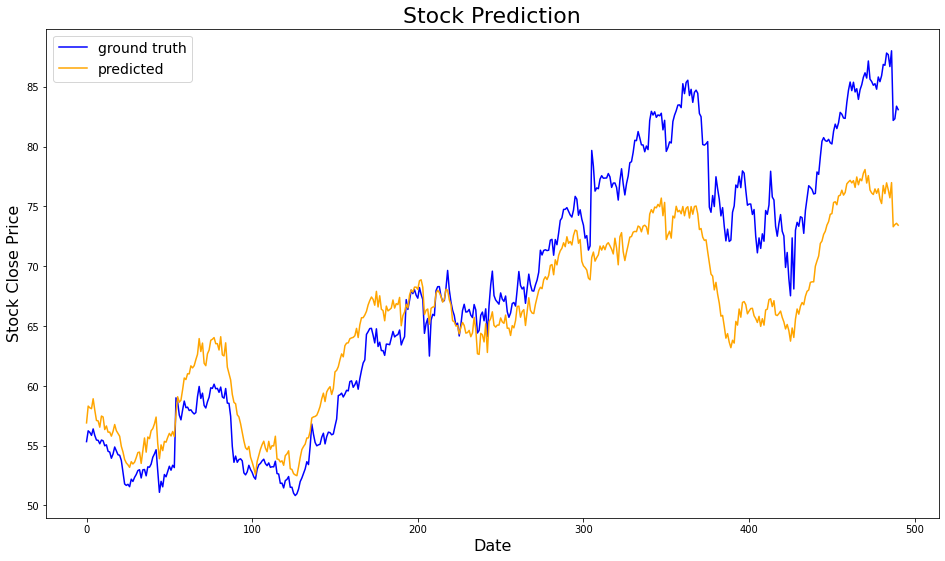

In [94]:
n_days = None
plt.figure(figsize=(16, 9))
plt.title("Stock Prediction", size=22)
plt.ylabel("Stock Close Price", size=16)
plt.xlabel("Date", size=16)
plt.plot( nike_y_test_sc[:-7], c="b", label="ground truth")
plt.plot( y_pred_sc[7:], c="orange", label="predicted")
plt.legend(fontsize=14)
plt.show()

## Double layer LSTM

In [ ]:
wandb.init(project="my-test-project", reinit=True)

In [ ]:
config = {
    "epochs": 50,
    "batch_size": 1,
    "model": "one-layer-LSTM",
    "neurons-per-layer": 300
}

In [ ]:
wandb.config.update({"dataset": "nike-X-scaled-y-skaled"})

In [ ]:
batch_size = 16
neurons = 200

In [ ]:
nike_X_train.shape

In [ ]:
model = Sequential()
model.add(Input(shape=(nike_X_train.shape[1], nike_X_train.shape[2])))
model.add(LSTM(config["neurons-per-layer"], stateful=False, return_sequences=True))
model.add(LSTM(config["neurons-per-layer"], stateful=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(nike_X_train, nike_y_train, epochs=config["epochs"], shuffle=False, callbacks=[WandbCallback()])

In [ ]:
wandb.finish()

In [ ]:
model.summary()

In [ ]:
y_pred = model.predict(nike_X_test)

In [ ]:
y_pred

In [ ]:
nike_y_test

In [ ]:
nike_X_test.shape

In [ ]:
y_pred_sc = skaler.inverse_transform(
    np.concatenate([nike_X_test.reshape(nike_X_test.shape[0], -1), y_pred], 
                   axis=1))[:, -1]

In [ ]:
nike_y_test_sc = skaler.inverse_transform(
    np.concatenate([nike_X_test.reshape(nike_X_test.shape[0], -1), nike_y_test.reshape(-1, 1)], 
                   axis=1))[:, -1]

In [ ]:
y_pred_sc.shape

In [ ]:
nike_y_test_sc.shape

In [ ]:
y_pred_sc[0]

In [ ]:
nike_y_test_sc[0]

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [ ]:
mean_absolute_error(y_pred_sc, nike_y_test_sc)

In [ ]:
mean_absolute_percentage_error(nike_y_test_sc, y_pred_sc)

In [ ]:
model.evaluate(nike_X_test, nike_y_test)

# Visualization

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
n_days = None
plt.figure(figsize=(16, 9))
plt.title("Stock Prediction", size=22)
plt.ylabel("Stock Close Price", size=16)
plt.xlabel("Date", size=16)
plt.plot( nike_y_test_sc[:n_days], c="b", label="ground truth")
plt.plot( y_pred_sc[:n_days], c="orange", label="predicted")
plt.legend(fontsize=14)

In [ ]:
plt.figure(figsize=(16, 9))
plt.title("Nike Stock Train Data", size=22)
plt.ylabel("Stock Close Price", size=16)
plt.xlabel("Date", size=16)
plt.plot(nike_train.index.values, nike_train.iloc[:,:-1]["Close"], c="b", label="price")
plt.legend(fontsize=14)